In [22]:
from glob import glob
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

# Data overview

The FWI operates by predicting the responses of fuel moisture to atmospheric forcings at different soil depths and by combining these to derive fire behavior indices in terms of ease of spread and intensity. The relative humidity, temperature, total precipitation, and wind speed are used for FWI calculation.

# File sorting

The time is encoded in the filename. Eg,<br>
` 'ECMWF_FO_20190401_1200_hr_rh.nc',`<br>
` 'ECMWF_FO_20190401_1200_hr_t2.nc',`<br>
` 'ECMWF_FO_20190401_1200_hr_tp.nc',`<br>
` 'ECMWF_FO_20190401_1200_hr_wspeed.nc'`<br>

Sorting files to get deterministic order when loaded:

In [23]:
file_list = glob('/nvme1/fwi-forcings/ECMWF_FO_2019*.nc')

In [43]:
files = sorted(sorted(file_list),
               key=lambda x: int(x.split("2019")[1].split("_1200_hr_")[0][:2])*100 + int(x.split("2019")[1].split("_1200_hr_")[0][2:]))

*Approx 6 months -> 184 * 4 (number of variables)*

In [25]:
files = files[:736]

Saving the files in a separate location (once) to prevent unintended modification.

In [21]:
# import shutil
# for file in files:
#     shutil.copy(file, '/nvme0/data_deepfwi/fwi-forcings')

# Preprocessing

Each file contains the observation along with 9 day forecast.

In [35]:
xr.open_dataset(files[0], engine='h5netcdf').time

<xarray.DataArray 'time' (time: 10)>
array(['2019-04-01T00:00:00.000000000', '2019-04-02T00:00:00.000000000',
       '2019-04-03T00:00:00.000000000', '2019-04-04T00:00:00.000000000',
       '2019-04-05T00:00:00.000000000', '2019-04-06T00:00:00.000000000',
       '2019-04-07T00:00:00.000000000', '2019-04-08T00:00:00.000000000',
       '2019-04-09T00:00:00.000000000', '2019-04-10T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-04-01 2019-04-02 ... 2019-04-10
Attributes:
    standard_name:  time
    axis:           T

Selecting only the actual value

In [29]:
def preprocess(d):
    return d.isel(time=slice(0,1))

h5netcdf engine gives better I/O speed.

In [ ]:
proc = xr.open_mfdataset(files, preprocess=preprocess, engine='h5netcdf')

**Pixel resolution**: *2560x5120*<br>
**Longitude resolution**: 0.0703125<br>
**Latitude resolution**: 0.06971<br>
*Should match with fwi-forcings to not require interpolation*

In [37]:
proc

,Array,Chunk
Bytes,9.65 GB,52.43 MB
Shape,"(184, 2560, 5120)","(1, 2560, 5120)"
Count,736 Tasks,184 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,9.65 GB,52.43 MB
Shape,"(184, 2560, 5120)","(1, 2560, 5120)"
Count,736 Tasks,184 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


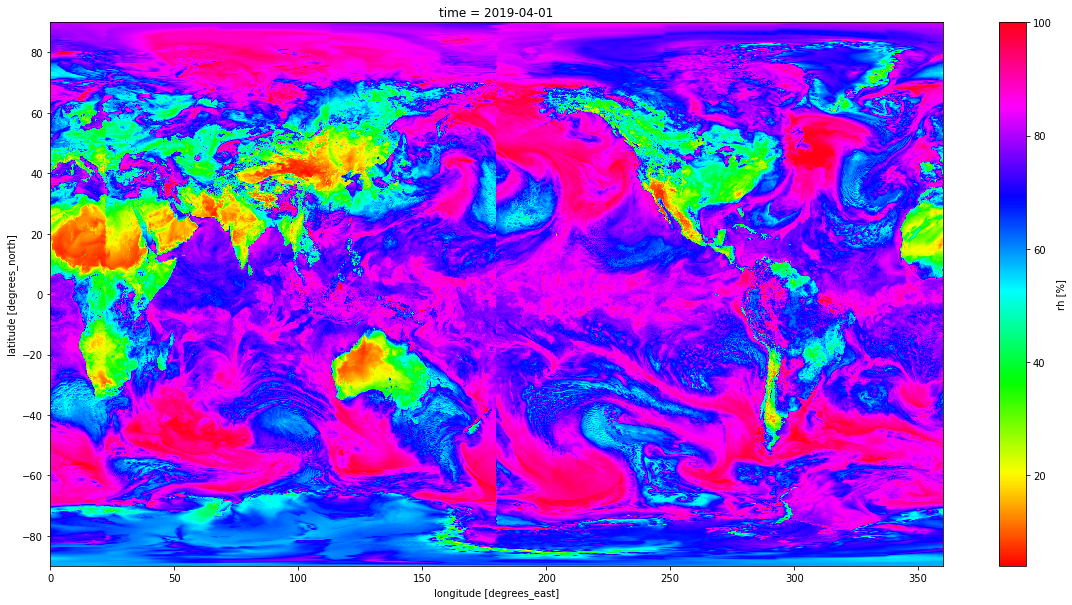

In [31]:
plt.figure(figsize = (20,10))
proc.rh[0].plot(cmap='hsv')

*Notice above the discontinuity in middle*<br>
Shifting the frame:

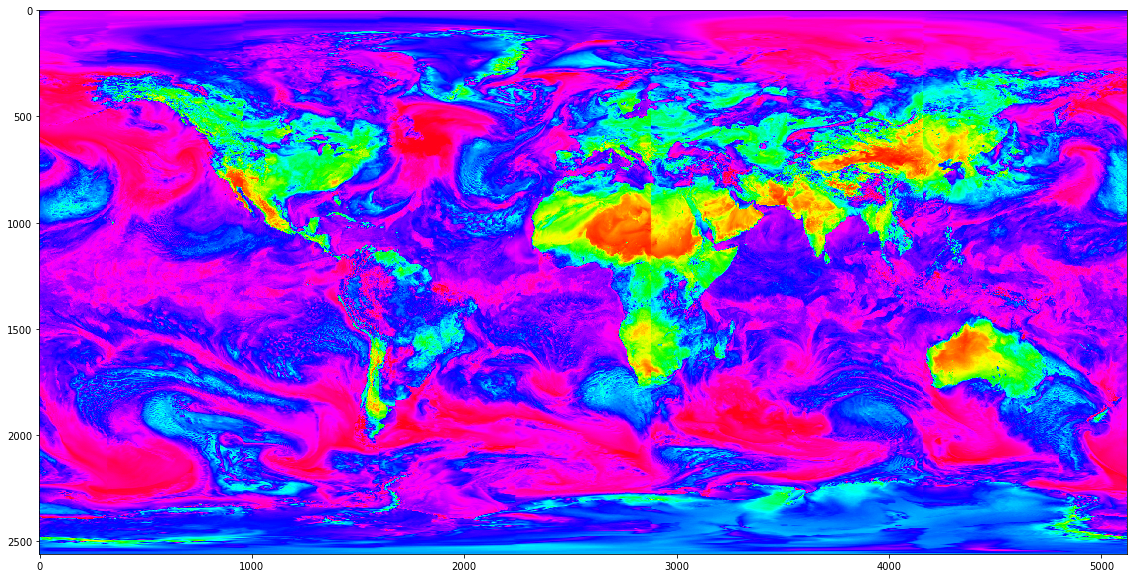

In [33]:
plt.figure(figsize = (20,10))
plt.imshow(np.concatenate((proc.rh[0].values[:,2560:], proc.rh[0].values[:,:2560]), axis=1), cmap='hsv')

Checking for NaN values.

In [42]:
for i in proc.data_vars:
    print(np.isnan(proc[i][0].values).any())

False
False
False
False


Printing stats.

In [45]:
def stats(x):
    tmp = x.mean().values
    print('mean', tmp)
    print('mad', abs(x-tmp).mean().values)
    print('var', x.var().values)
    print('min', x.min().values)
    print('max', x.max().values)

In [46]:
stats(proc.rh)

mean 72.03445
mad 14.256372
var 354.31964
min 0.059931565
max 100.064285


In [47]:
stats(proc.t2)

mean 281.2624
mad 16.594109
var 480.72104
min 193.66562
max 324.16202


In [48]:
stats(proc.tp)

mean 2.4925985
mad 3.0615451
var 40.601112
min 0.0
max 1062.0919


In [49]:
stats(proc.wspeed)

mean 6.5504117
mad 2.9618351
var 13.947631
min 6.866455e-05
max 47.25583
